<a href="https://colab.research.google.com/github/abiraaaaaaf/ML-DL-Python-Introduction/blob/main/Session_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Transfer Learning

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

A dataset containing several thousand images of cats and dogs! 

Download and extract a zip file containing the images, then create a tf.data.Dataset for training and validation using the tf.keras.utils.image_dataset_from_directory utility

In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

68616192/68606236 [==============================] - 0s 0us/step
Found 2000 files belonging to 2 classes.


In [3]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


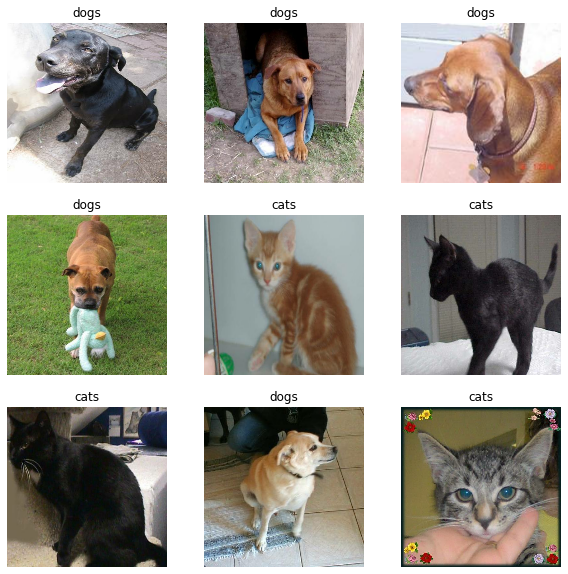

In [4]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

As the original dataset doesn't contain a test set, you will create one. To do so, determine how many batches of data are available in the validation set using tf.data.experimental.cardinality, then move 20% of them to a test set.

In [5]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [6]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


Use buffered prefetching to load images from disk without having I/O become blocking.

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [8]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

The result of data augmentation:

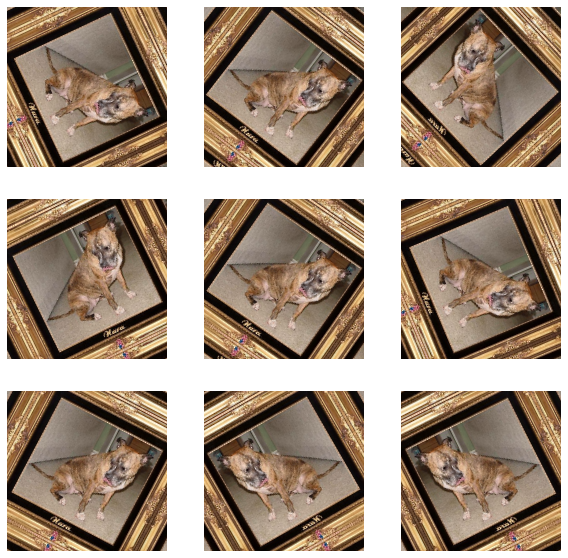

In [11]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[6]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In a moment, you will download tf.keras.applications.MobileNetV2 for use as your base model. 

This model expects pixel values in [-1, 1], but at this point, the pixel values in your images are in [0, 255]. To rescale them, use the preprocessing method included with the model.

In [12]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

Create the base model from the pre-trained convnets:

In [13]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9420800/9406464 [==============================] - 0s 0us/step


In [14]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


Freeze the base model:

**Other option:** base_model.trainable = True


In [15]:
base_model.trainable = False

In [16]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

Add a classification head:

In [17]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [18]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [19]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [20]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [22]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 16s 516ms/step - loss: 0.8668 - accuracy: 0.4307


In [23]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.87
initial accuracy: 0.43


In [24]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 59s 877ms/step - loss: 0.8696 - accuracy: 0.4725 - val_loss: 0.5919 - val_accuracy: 0.6064
Epoch 2/10
63/63 [==============================] - 52s 824ms/step - loss: 0.6302 - accuracy: 0.6170 - val_loss: 0.4322 - val_accuracy: 0.7302
Epoch 3/10
63/63 [==============================] - 51s 804ms/step - loss: 0.4928 - accuracy: 0.7220 - val_loss: 0.3334 - val_accuracy: 0.8057
Epoch 4/10
63/63 [==============================] - 50s 793ms/step - loss: 0.4019 - accuracy: 0.8025 - val_loss: 0.2672 - val_accuracy: 0.8676
Epoch 5/10
63/63 [==============================] - 49s 777ms/step - loss: 0.3406 - accuracy: 0.8375 - val_loss: 0.2314 - val_accuracy: 0.8936
Epoch 6/10
63/63 [==============================] - 50s 788ms/step - loss: 0.3094 - accuracy: 0.8550 - val_loss: 0.1986 - val_accuracy: 0.9183
Epoch 7/10
63/63 [==============================] - 50s 786ms/step - loss: 0.2833 - accuracy: 0.8805 - val_loss: 0.1728 - val_accuracy: 0.9381

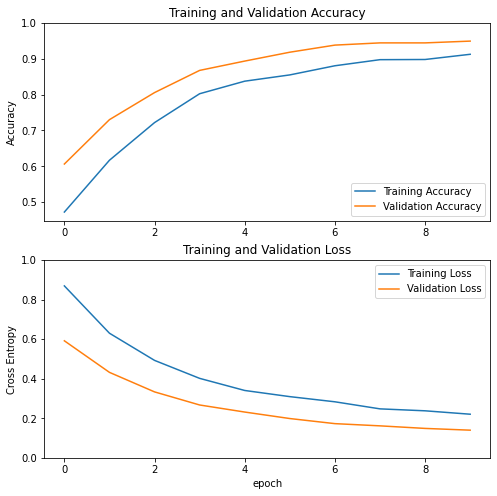

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Link: https://www.tensorflow.org/tutorials/images/transfer_learning

## RNN

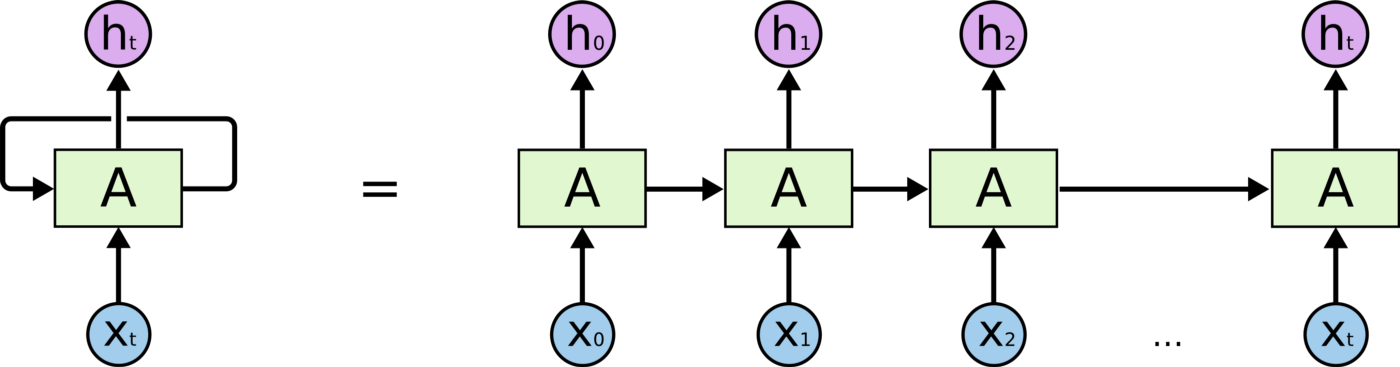

## LSTM

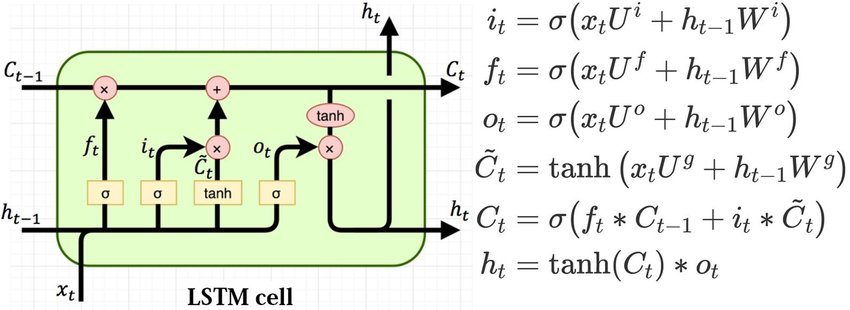

## GRU

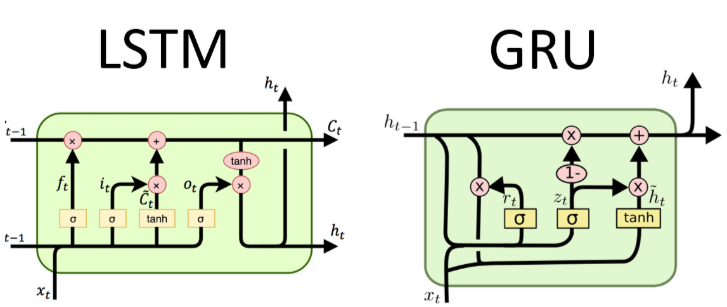

In [ ]:
# Author: Robert Guthrie

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

In [ ]:
lstm = nn.LSTM(3, 3)  # Input dim is 3, output dim is 3
inputs = [torch.randn(1, 3) for _ in range(5)]  # make a sequence of length 5

# initialize the hidden state.
hidden = (torch.randn(1, 1, 3),
          torch.randn(1, 1, 3))
for i in inputs:
    # Step through the sequence one element at a time.
    # after each step, hidden contains the hidden state.
    out, hidden = lstm(i.view(1, 1, -1), hidden)

# alternatively, we can do the entire sequence all at once.
# the first value returned by LSTM is all of the hidden states throughout
# the sequence. the second is just the most recent hidden state
# (compare the last slice of "out" with "hidden" below, they are the same)
# The reason for this is that:
# "out" will give you access to all hidden states in the sequence
# "hidden" will allow you to continue the sequence and backpropagate,
# by passing it as an argument  to the lstm at a later time
# Add the extra 2nd dimension
inputs = torch.cat(inputs).view(len(inputs), 1, -1)
hidden = (torch.randn(1, 1, 3), torch.randn(1, 1, 3))  # clean out hidden state
out, hidden = lstm(inputs, hidden)
print(out)
print(hidden)

tensor([[[-0.0187,  0.1713, -0.2944]],

        [[-0.3521,  0.1026, -0.2971]],

        [[-0.3191,  0.0781, -0.1957]],

        [[-0.1634,  0.0941, -0.1637]],

        [[-0.3368,  0.0959, -0.0538]]], grad_fn=<StackBackward0>)
(tensor([[[-0.3368,  0.0959, -0.0538]]], grad_fn=<StackBackward0>), tensor([[[-0.9825,  0.4715, -0.0633]]], grad_fn=<StackBackward0>))


### Character-level text generation with LSTM

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import random
import io

Preparing the data:


In [ ]:
path = keras.utils.get_file(
    "nietzsche.txt", origin="https://s3.amazonaws.com/text-datasets/nietzsche.txt"
)
with io.open(path, encoding="utf-8") as f:
    text = f.read().lower()
text = text.replace("\n", " ")  # We remove newlines chars for nicer display
print("Corpus length:", len(text))

chars = sorted(list(set(text)))
print("Total chars:", len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

# cut the text in semi-redundant sequences of maxlen characters
maxlen = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i : i + maxlen])
    next_chars.append(text[i + maxlen])
print("Number of sequences:", len(sentences))

x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

614400/600901 [==============================] - 1s 1us/step
Corpus length: 600893
Total chars: 56
Number of sequences: 200285


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Build the model: a single LSTM layer


In [ ]:
model = keras.Sequential(
    [
        keras.Input(shape=(maxlen, len(chars))),
        layers.LSTM(128),
        layers.Dense(len(chars), activation="softmax"),
    ]
)
optimizer = keras.optimizers.RMSprop(learning_rate=0.01)
model.compile(loss="categorical_crossentropy", optimizer=optimizer)

Preparing the text sampling function:

In [ ]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype("float64")
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

Training the model:

In [ ]:
epochs = 40
batch_size = 128

for epoch in range(epochs):
    model.fit(x, y, batch_size=batch_size, epochs=1)
    print()
    print("Generating text after epoch: %d" % epoch)

    start_index = random.randint(0, len(text) - maxlen - 1)
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print("...Diversity:", diversity)

        generated = ""
        sentence = text[start_index : start_index + maxlen]
        print('...Generating with seed: "' + sentence + '"')

        for i in range(400):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.0
            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]
            sentence = sentence[1:] + next_char
            generated += next_char

        print("...Generated: ", generated)
        print()

1565/1565 [==============================] - 200s 126ms/step - loss: 1.9316

Generating text after epoch: 0
...Diversity: 0.2
...Generating with seed: "fers upon the free spirit the perilous p"
...Generated:  reas and perhaps to the most of the most in the constility of the most religion to the soluled to the most of the morality and the most of the most of the most man and state and the reality of the sore the reality of the sactificed to the possice the high the sactical for the most of the soll the morality and morality and the sole the such and the moral to the spirit to the sactificed to the most 

...Diversity: 0.5
...Generating with seed: "fers upon the free spirit the perilous p"
...Generated:  arsition (the most real therefore is there is a general desire and the good not the spirit of the man which the sole the heart himself in the sach and itself for the poselly of the liken are reality of concersion to the lowe which in the perposted and constingtion to the same and philoso

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


...Generated:  ," "lifirious. unfailiesary force, i hourou preserve, which scheme sire may fineful coltblece.  2taisishs of ususe? to spean cases chemstill" moi them: and a litthing."--everyfore," and : "qualitions utance repress thingswippilous manfourn subject: the deporing  rileblath mat.""  160. comounu-tes that the classes.--could not shove of which indeded s=cccrings. woman ptailers of the hlastaperitary t

1565/1565 [==============================] - 203s 130ms/step - loss: 1.2803

Generating text after epoch: 17
...Diversity: 0.2
...Generating with seed: " is managed! woman does not understand w"
...Generated:  hich is the spirit of the sublimity of the sublimity of the sublimity of the soul man who seems to be the strange to the moral soul and present and actions and in the sublimity and in the sublimity and preaching the surestical soul and the morality of the sublimity of the conscience of the sublimity of the moral for the soul. it is a strain of the same man and the supers

https://wandb.ai/sauravmaheshkar/LSTM-PyTorch/reports/Using-LSTM-in-PyTorch-A-Tutorial-With-Examples--VmlldzoxMDA2NTA5

## Attention Module

https://towardsdatascience.com/attention-seq2seq-with-pytorch-learning-to-invert-a-sequence-34faf4133e53

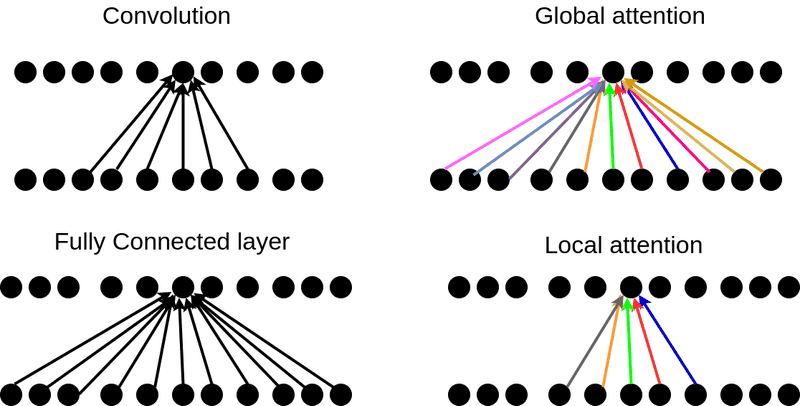

Visual Question Answering (VQA)

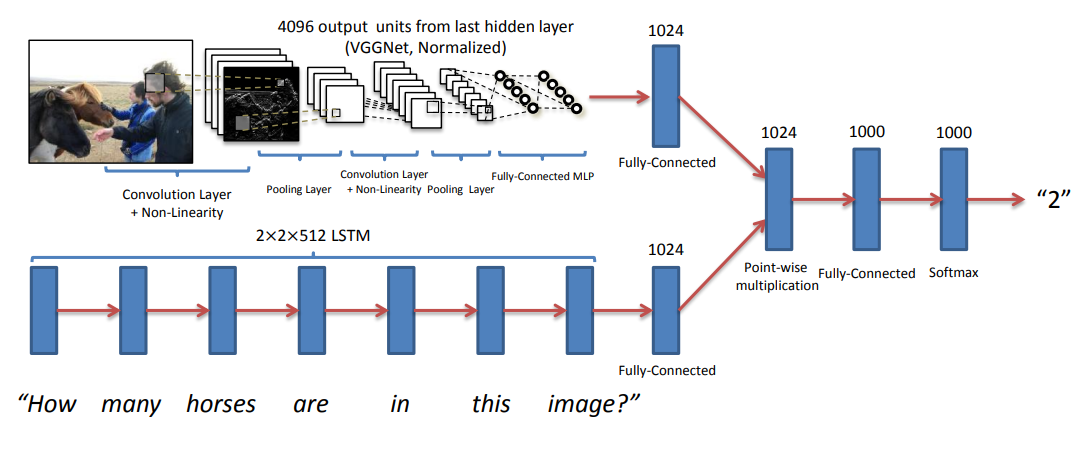

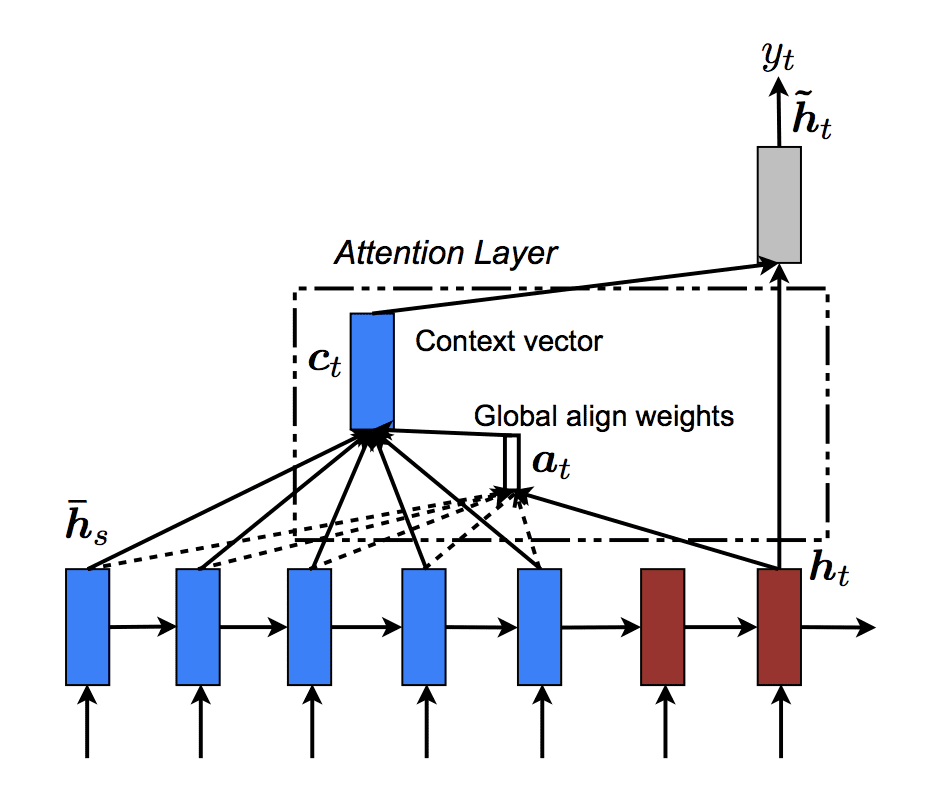